In [1]:
import pandas as pd
import statistics
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ttest_ind
from scipy import stats
import ptitprince as pt
import seaborn as sns
from IPython.display import display, HTML
pd.options.display.float_format = '{:.4f}'.format


In [2]:
male = [12,4,11,13,11,7,9,10,10,7,7,12,6,9,15,10,11,12,7,8,8,9,11,10,9,10,9,9,7,9,11,7,10,10,11,9,12,12,8,13,9,10,8,11,10,13,13,9,10,13]
female = [11,9,7,10,9,10,10,7,9,10,11,8,9,6,11,10,7,9,12,14,11,12,12,8,12,12,9,10,11,7,12,7,9,8,11,10,8,13,8,10,9,9,9,11,9,9,8,9,12,11]

male_df = pd.DataFrame(male).rename(columns={0:'Male'})
female_df = pd.DataFrame(female).rename(columns={0:'Female'})

df = pd.concat([male_df,female_df], axis=1)

#### Rationale 
The study aims to compare the mean time spent on cell phones by male and female college students per week. Fifty male and fifty female students were selected from Midwestern University and the number of hours per week spent talking on their cell phones determined. An independent samples t-test may be conducted to assess if there is a statistically significant difference between these groups at a significance level of $\alpha = 0.05$.

#### Variables
- Independent: Gender - categorical variable with two groups, male and female.
- Dependent: Time spent on cellphones - continuous variable, measured in hours per week.

#### Hypotheses
- **Null Hypothesis** ($H_0$): There is no significant difference in the mean time spent on cell phones between male and female students. 
$$H_0 = \mu_1 = \mu_2$$
    where $\mu_1 $ is the mean time for males and $\mu_2$ is the mean time for females.
- **Alternative Hypothesis** ($H_1$): There is a significant difference in the mean time spent on cell phones between male and female students. 
$$H_1 = \mu_1 \neq \mu_2$$
    where $\mu_1 $ is the mean time for males and $\mu_2$ is the mean time for females.

#### Significance Level
The significance level for this study is set at $\alpha = 0.05$. Hence, if the p-value obtained from the t-test is less than 0.05, we reject the null hypothesis which implies that there is a significant difference between the groups. Otherwise, we fail to reject the null hypothesis.


In [6]:
def describe(data, df):
    count = df.count().to_frame(name="Count").transpose()
    mode = pd.Series(data).mode().tolist()
    measures = df.agg(['median', 'mean', 'std', 'var', 'skew', 'kurt'])
    measures = measures.rename(index={
        'median': 'Median','mean': 'Mean','std': 'Standard Deviation',
        'var': 'Variance','skew': 'Skewness','kurt': 'Kurtosis'
    })
    measures.loc['Mode'] = mode[0]
    min_val = df.min().to_frame(name="Minimum").transpose()
    max_val = df.max().to_frame(name="Maximum").transpose()

    percentiles = df.quantile([0.25, 0.50, 0.75, 0.90, 0.95])
    percentiles = percentiles.rename(index={
        0.25: '25th percentile', 0.5: '50th percentile',
        0.75: '75th percentile', 0.9: '90th percentile', 0.95: '95th percentile'
    })

    skew_err_formula = lambda x: np.sqrt((6 * len(x) * (len(x)-1)) / ((len(x)-2) * (len(x)+1) * (len(x)+3)))
    skew_stderror = df.apply(skew_err_formula)
    skew_stderror = skew_stderror.to_frame(name='Std. Error of Skewness').transpose()

    kurt_err_formula = lambda x: np.sqrt((24 * len(x) * (len(x) - 1) * (len(x) - 1)) / 
                                           ((len(x) - 3) * (len(x) - 2) * (len(x) + 3) * (len(x) + 5)))
    kurt_stderror = df.apply(kurt_err_formula)
    kurt_stderror = kurt_stderror.to_frame(name='Std. Error of Kurtosis').transpose()
    table_df = pd.concat([count, measures,skew_stderror, kurt_stderror, min_val, max_val, percentiles])
    table_df = table_df.reindex(['Count','Mode','Median', 'Mean', 'Standard Deviation', 'Variance', 
                                 'Skewness', 'Std. Error of Skewness','Kurtosis', 'Std. Error of Kurtosis', 
                                 'Minimum', 'Maximum', '25th percentile','50th percentile', '75th percentile', 
                                 '90th percentile', '95th percentile'])
    return table_df
    
male_stats = describe(male, male_df)
female_stats = describe(female, female_df)

display(HTML("""<h4>Descriptive Statistical Summary</h4>"""))
display(pd.concat([male_stats,female_stats], axis=1))
display(HTML("""<p>Note: Only the first mode is displayed.</p> """))

,Male,Female
Count,50.0000,50.0000
Mode,9.0000,9.0000
Median,10.0000,9.5000
Mean,9.8200,9.7000
Standard Deviation,2.1542,1.7757
Variance,4.6404,3.1531
Skewness,-0.1147,0.1344
Std. Error of Skewness,0.3366,0.3366
Kurtosis,0.1773,-0.4418
Std. Error of Kurtosis,0.6619,0.6619


#### Assumption Checks

**Assumption 1.** The dependent variable (Time) is a continuous level. \
**Assumption 2.** The independent variable (Gender) is a categorical variable and consists of two independent groups (Male, Female) \
**Assumption 3.** Each participant is present only to one group.


**Assumption 4. Outliers.** 

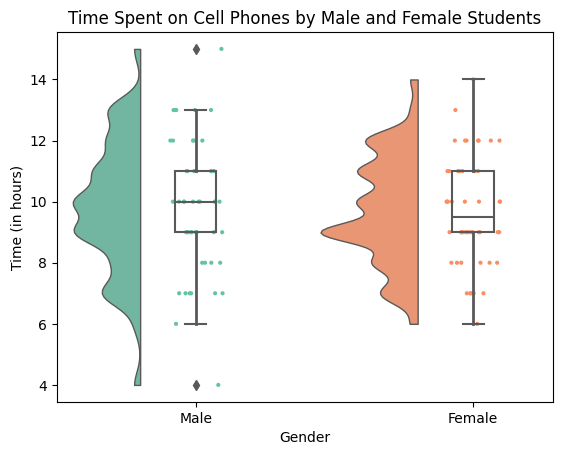

In [9]:
df_melted = df.melt(var_name='Gender', value_name='Time')
pt.RainCloud(data=df_melted, x='Gender', y='Time', bw=.2)

plt.title('Time Spent on Cell Phones by Male and Female Students')
plt.xlabel('Gender')
plt.ylabel('Time (in hours)')
plt.show()

By visual inspection of the plots, some outliers are present in the Male group and none in the Female group. 

**Assumption 5. Normality**

In [10]:
male_data =male_df['Male']
female_data = df['Female']
shapiro_male = shapiro(male_data)
shapiro_female = shapiro(female_data)
shapiro_male = pd.DataFrame({'Male': shapiro_male}).transpose()
shapiro_female = pd.DataFrame({'Female': shapiro_female}).transpose()
display(HTML("""<h5>Test for Normality (Shapiro-Wilk)</h5>"""))
display(pd.concat([shapiro_male,shapiro_female]).rename(columns={0:'Statistic', 1:'p-value'}))

,Statistic,p-value
Male,0.9747,0.3540
Female,0.9639,0.1292


The test statistic for the Male group (0.9747) and Female group (0.9639) indicate that the distributions resemble a normal distribution. According to the Shapiro-Wilk test, the dependent variable (Time) for each group, Male and Female, is normally distributed (p > 0.05).

**Assumption 6. Homogeneity of Variances**

In [11]:
levene_test = levene(male_data, female_data)
levene_df = pd.DataFrame({'Time': levene_test}).rename(index={0:'F', 1:'p'}).transpose()
levene_df['df'] =[1]

display(HTML("""<h5>Test of Equality of Variances (Levene's)</h5>"""))
display(levene_df)

,F,p,df
Time,0.6943,0.4067,1


According to Levene's test of equality of variances, there is not enough statistic evidence to imply a significant difference between the variances of the groups (Male, Female) on their mean time spent on cell phone per week.

#### Independent Samples t-Test

In [88]:
t_test = ttest_ind(male_data, female_data)
t_test_df = pd.DataFrame({'Time': t_test}).rename(index={0:'t', 1:'p'}).transpose()
dof = (len(male_data) + len(female_data))-2
t_test_df['df'] = [dof]

mean_male = np.mean(male_data)
mean_female = np.mean(female_data)
mean_difference = mean_male - mean_female
stdev_male = np.std(male_data, ddof=1)
stdev_female = np.std(female_data,ddof=1)

se_male = stdev_male/(np.sqrt(len(male_data)))
t_male = stats.t.ppf(1 - 0.05/2, len(male_data -1))
se_female = stdev_female/(np.sqrt(len(female_data)))
t_female = stats.t.ppf(1 - 0.05/2, len(female_data -1))

CI_male = round((mean_male - t_male*se_male),3), round((mean_male + t_male*se_male),3)
CI_female = round((mean_female - t_female*se_female),3), round((mean_female + t_female*se_female),3)
                          
se_diff =  np.sqrt(((stdev_male)**2/len(male_data)) + ((stdev_female)**2/len(female_data)))
t_crit = stats.t.ppf(1 - 0.05/2, dof)

CI_lower = mean_difference - t_crit * se_diff
CI_upper = mean_difference + t_crit * se_diff
CI = round(CI_lower,3), round(CI_upper,3)
misc = pd.DataFrame({'Mean Difference':[mean_difference], 'SE Difference':[se_diff], '95% CI for Mean Difference': [CI]}).rename(index={0:'Time'})
display(HTML("""<h5>Independent Samples T-Test</h5>"""))
display(pd.concat([t_test_df, misc], axis=1))

CI_male_df =pd.DataFrame({'Male' : [CI_male]})

CI_female_df = pd.DataFrame({'Female' : [CI_female]})

display(pd.concat([CI_male_df, CI_female_df], axis=1).rename(index={0:'95% CI for Population Mean'}).transpose())

,t,p,df,Mean Difference,SE Difference,95% CI for Mean Difference
Time,0.3039,0.7618,98,0.1200,0.3948,"(-0.663, 0.903)"


,95% CI for Population Mean
Male,"(9.208, 10.432)"
Female,"(9.196, 10.204)"


#### Report Summary
The Shapiro-Wilk test revealed that the mean time for both Male and Female groups were normally distributed and the Levene's test for equality of variances suggest that  there was homogeneity of variances. Therefore, an independent samples t-test was conducted to compare mean time spent on cell phones per week by male and female students of Midwestern University with a 95% confidence interval (CI) for the mean difference. 

The results indicated no significant difference between the Male group (M = 9.82, SD = 2.154) and Female group (M = 9.70, SD = 1.78), t(98) = 0.304, p > 0.05. The mean difference obtained was 0.120, with a 95% confidence interval ranging between -0.663 and 0.903. These results do not provide enough statistical evidence to reject the null hypothesis, hence we can conclude that there is no significant difference between the mean time spent on cell phones by male and female students. These findings may suggest that cell phone usage do not differ significantly based on gender.

#### Recommendations



Since there were no violations to the tests for normality and equality of variance, the sample size may be considered suitable enough for this test. However, testing with larger samples may be conducted for better generalization of findings to make better inferences about a larger population.

The researchers may also consider exploring additional variables and investigating other influences that may affect individuals' time spent on cell phone use especially since there were some outliers in the data. They may want to look into factors such as age, field of study, employment, or socioeconomic background. Investigating such factors may lead to a better understanding of how people spend time on their cell phones.